# Initial Runs

For ease of use, I've made a copy of everything essential for running in it's own section since it was getting messy. 

To Talk about: 
* Normalizing having an interfering effect with the data
* PIL Image conversion? 
* CIFAR-10 works slightly better
* Can't run shift module correctly due to lack of gpu for CUDA


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_PATH = "./data"
MODEL_PATH = "./models"

In [ ]:
# Hyperparameters
EPOCHS = 6
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [ ]:
# MNIST Dataset
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

# CIFAR-10 Dataset
# a transform to apply to data (convert to Tensor, then normalize w/ CIFAR-10's mean & sd on RGB channels)
trans = transforms.Compose([#transforms.ToPILImage(), 
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

# CIFAR-10 
train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=False, transform=trans)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, transform=trans)
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [ ]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [ ]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super(CIFARConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16 * 16 * 32, 2000)
        self.fc2 = nn.Linear(2000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [ ]:
# For MNIST Model
modelMNIST = MNISTConvNet()
modelMNIST.load_state_dict(torch.load(MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt'))

# For CIFAR-10 Model
modelCIFAR = CIFARConvNet()
modelCIFAR.load_state_dict(torch.load(MODEL_PATH + 'cifar_conv_net_1(conv)_2_model.ckpt'))

In [ ]:
# To evaluate a model's baseline accuracy
def evaluateAccuracy(model, test_loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

        print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

The following few functions are mostly functions for testing variance

In [ ]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2

In [ ]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a ndarray or tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    if type(inp) != torch.Tensor:
        try:
            inp =  torch.Tensor(inp)
        except:
            print("Error: Input of type {} couldn't be converted to PyTorch tensor!".format(type(inp)))
            raise
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [ ]:
# Main function
def varianceTest(model, sigmas, dataset, epochs = 5):
    ''' Finds the variance of model over X+e, where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of var(model(X+e)) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    outputVariance = []
    outputVarianceSTD = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(varModel(model, test_loader).item())
        tot = np.array(tot)
        outputVariance.append(tot.mean())
        outputVarianceSTD.append(tot.std())
        print("Variance with noise std {} is {}. STD is {}".format(sigma, outputVariance[-1], outputVarianceSTD[-1]))
    return outputVariance, outputVarianceSTD

In [ ]:
def display(sigmas, results, resultsSTD):
    results = np.array(results)
    resultsSTD = np.array(resultsSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigmas, list(results-resultsSTD), list(results+resultsSTD), color='b',alpha=.2)
    plt.plot(sigmas, results, lw=2)
    plt.xlabel('Sigma', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Sigma vs. Variance')
    plt.show()

# Objective 1

Setting up the MNIST Dataset and creating a CNN in PyTorch

## Imports, Hyperparameters, and Loading Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

DATA_PATH = "./data"
MODEL_PATH = "./models"

In [2]:
# Hyperparameters
EPOCHS = 6
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [3]:
# a transform to apply to data (convert to Tensor, then normalize w/ MNIST's mean & sd)
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=trans)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

In [4]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

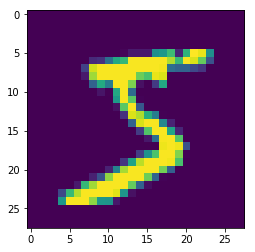

In [10]:
plt.imshow(train_dataset.train_data[0])
plt.show()

To load the model:

In [5]:
model = ConvNet()
model.load_state_dict(torch.load(MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt'))

NameError: name 'ConvNet' is not defined

## Training a Good Convolutional Neural Network 

The ConvNet I chose has the following layers:
   * Layer 1 (Convolutional): 32 5x5 convolutional filters --> ReLU nonlinearity --> 2x2 Maxpool
   * Dropout 
   * Layer 2 (Linear): 14x14x32 --> 1000 Fully Connected layer
   * Layer 3 (Output): 1000 --> 10 Fully Connected Layer 
   * SoftMax included in nn.CrossEntropyLoss()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [83]:
model = ConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [68]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/600], Loss: 0.2542, Accuracy: 89.00%
Epoch [1/6], Step [200/600], Loss: 0.1430, Accuracy: 93.00%
Epoch [1/6], Step [300/600], Loss: 0.2477, Accuracy: 92.00%
Epoch [1/6], Step [400/600], Loss: 0.2554, Accuracy: 93.00%
Epoch [1/6], Step [500/600], Loss: 0.1063, Accuracy: 97.00%
Epoch [1/6], Step [600/600], Loss: 0.1122, Accuracy: 96.00%
Epoch [2/6], Step [100/600], Loss: 0.1875, Accuracy: 94.00%
Epoch [2/6], Step [200/600], Loss: 0.0763, Accuracy: 98.00%
Epoch [2/6], Step [300/600], Loss: 0.1185, Accuracy: 96.00%
Epoch [2/6], Step [400/600], Loss: 0.1038, Accuracy: 96.00%
Epoch [2/6], Step [500/600], Loss: 0.0706, Accuracy: 97.00%
Epoch [2/6], Step [600/600], Loss: 0.1575, Accuracy: 96.00%
Epoch [3/6], Step [100/600], Loss: 0.1800, Accuracy: 92.00%
Epoch [3/6], Step [200/600], Loss: 0.0743, Accuracy: 98.00%
Epoch [3/6], Step [300/600], Loss: 0.1216, Accuracy: 96.00%
Epoch [3/6], Step [400/600], Loss: 0.0305, Accuracy: 99.00%
Epoch [3/6], Step [500/600], Loss: 0.022

## Testing the accuracy

In [151]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
    
    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
    
# Save the model and plot
#torch.save(model.state_dict(), MODEL_PATH + 'conv_net_1(conv)_2_model.ckpt')

Test Accuracy of the model on the 10000 test images: 98.35000000000001 %


Now we find the variance of the output of our model

In [35]:
model.eval()

results = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        results.append(predicted)
    
results = torch.cat(results) 
variance = (results.float().std()/9)**2
print(variance)

tensor(0.1039)


In [36]:
# Compare to the pre-sample variance
(test_dataset.test_labels.float().std()/9)**2

tensor(0.1035)

## Plot the accuracy

In [75]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, export_png
from bokeh.models import LinearAxis, Range1d
import numpy as np

output_notebook() # for printing in jupyter

p = figure(y_axis_label='Loss', width=850, y_range=(0,1), title='PyTorch ConvNet Results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0,end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(acc_list)), acc_list, color='red')
export_png(p, filename='ConvNetAccLoss.png')

Loading BokehJS ...

'/Users/tylerzhu/Desktop/tyleryzhu/pallas-starter-project/ConvNetAccLoss.png'

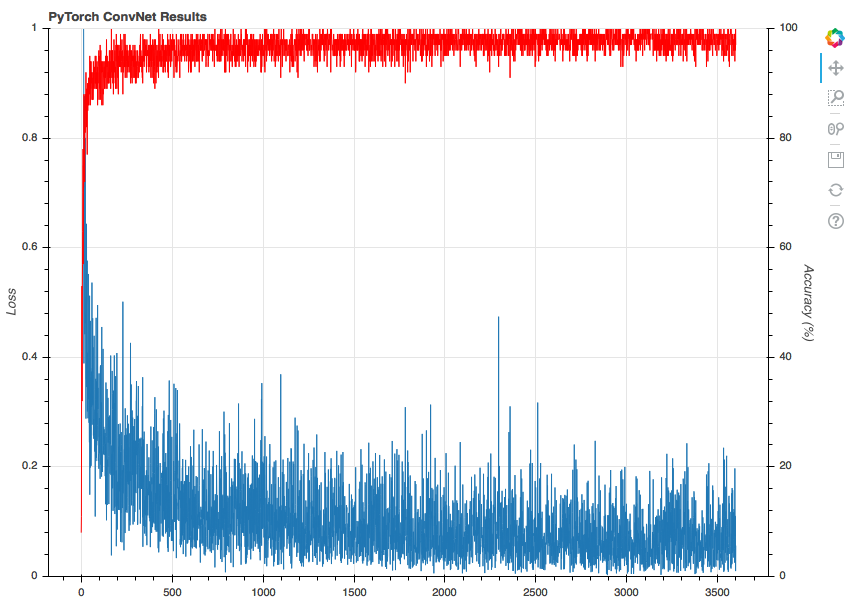

In [81]:
from IPython.display import Image
Image('./ConvNetAccLoss.png')

## Creating a function for measuring variance 

In [49]:
def varModel(model, loader):
    ''' Returns the variance of model over samples as a PyTorch tensor.
    
        Inputs:
        model: a PyTorch Neural Network.
        samples: a PyTorch Data Loader of the samples to test (usually test_loader)'''
    
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            results.append(predicted)

    results = torch.cat(results).float() 
    std = results.std()/(results.max()-results.min())
    return std**2

In [138]:
varModel(model, test_loader).item()

0.10240806639194489

## Creating samples with noise

TODO: Multithread the functions here so it runs faster

In [32]:
def addNoise(inp, sigma, clamp = True): 
    ''' Adds Gaussian noise N(0, sigma) to a ndarray or tensor inp.
        Clamps values to [0, 255]
        Returns a FloatTensor with noise added.'''
    if type(inp) != torch.Tensor:
        try:
            inp =  torch.Tensor(inp)
        except:
            print("Error: Input of type {} couldn't be converted to PyTorch tensor!".format(type(inp)))
            raise
    inp = inp.type(torch.FloatTensor)
    shape = inp.shape 
    noise = torch.tensor(np.random.normal(0, sigma, size = shape)).type(torch.FloatTensor)
    return torch.clamp(noise+inp, 0, 255) if clamp else noise+inp #to clamp or not to clamp? 

In [18]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans, download=False)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

Here I'm just plotting the images to see what kind of noise I'm getting. I also clamped the values to the range [0,255] for more consistent performance. 

In [10]:
t = test_dataset.test_data[0]

In [21]:
type(t) == torch.Tensor

True

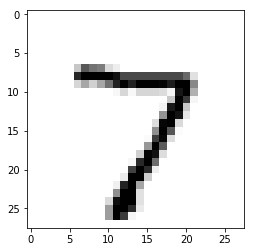

In [60]:
plt.imshow(t, cmap='Greys')

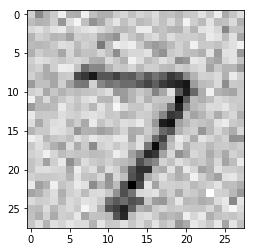

In [67]:
n = addNoise(t,50, False)
plt.imshow(n.type(torch.IntTensor), cmap='Greys')

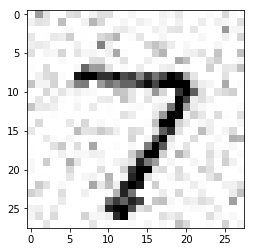

In [68]:
plt.imshow(torch.clamp(n.type(torch.IntTensor), 0, 255), cmap='Greys')

In [51]:
def varianceTest(model, sigmas, dataset, epochs = 5):
    ''' Finds the variance of model over X+e, where e = N(0, sigma) is Gaussian noise. 
        Each hyperparameter is run over epochs iterations. 
        
        Dataset is either 'mnist' or 'cifar10'
    
        Returns the average and s.d. of var(model(X+e)) where e = N(0, sigma) for each 
        sigma in sigmas over epochs number of iterations.'''
    if dataset not in ['mnist', 'cifar10']:
        print('Dataset {} not found!'.format(dataset))
        return 
    if dataset == 'mnist':
        trans = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307,), (0.3081,))])
    elif dataset == 'cifar10':
        trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
    outputVariance = []
    outputVarianceSTD = []
    for sigma in sigmas:
        print("Computing variance of f(Y) where noise has sigma =", sigma)
        tot = []
        for epoch in range(epochs): 
            print("Epoch {} of {}".format(epoch+1, epochs))
            if dataset == 'mnist':
                noisy_test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            elif dataset == 'cifar10':
                noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                                            transform=trans,download=False)
            for i in range(len(noisy_test_dataset.test_data)):
                noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], sigma)
            test_loader = DataLoader(dataset = noisy_test_dataset, batch_size=BATCH_SIZE, shuffle = False)
            tot.append(varModel(model, test_loader).item())
        tot = np.array(tot)
        outputVariance.append(tot.mean())
        outputVarianceSTD.append(tot.std())
        print("Variance with noise std {} is {}. STD is {}".format(sigma, outputVariance[-1], outputVarianceSTD[-1]))
    return outputVariance, outputVarianceSTD

In [186]:
sigs = np.linspace(0, 80, 9) 
print(sigs)

[ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [223]:
res, resSTD = varianceTest(model, sigs, epochs = 5)

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 0.0 is 0.10386093705892563. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 10.0 is 0.10394573360681533. STD is 3.667211929617332e-05
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 20.0 is 0.1038870245218277. STD is 3.676458343785538e-05
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 30.0 is 0.10375198870897293. STD is 8.672893644067376e-05
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 5
Epoch 2 of 5
Epoch 3 of 5
Epoch 4 of 5
Epoch 5 of 5
Variance with noise std 40.0 is 0.10337993949651718. STD is 0.00018889814023540202
Compu

In [72]:
def display(sigmas, results, resultsSTD):
    results = np.array(results)
    resultsSTD = np.array(resultsSTD)
    plt.figure(figsize=(10,6))
    plt.fill_between(sigmas, list(results-resultsSTD), list(results+resultsSTD), color='b',alpha=.2)
    plt.plot(sigmas, results, lw=2)
    plt.xlabel('Sigma', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.title('Sigma vs. Variance')
    plt.show()

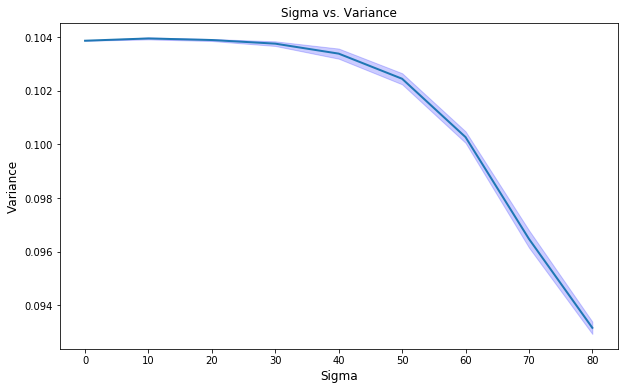

In [239]:
display(sigs, res, resSTD)

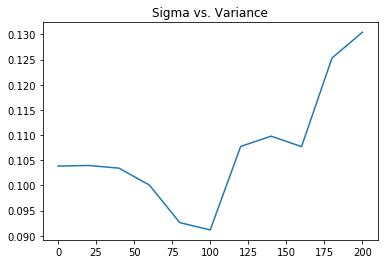

In [168]:
display(sigs, result)

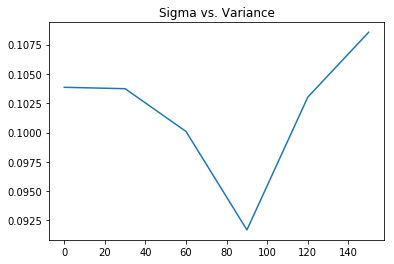

In [175]:
display(sigs, result)

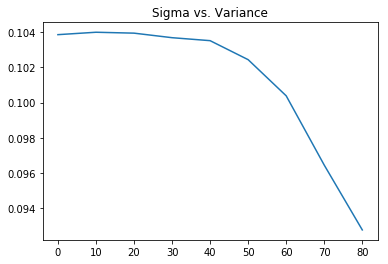

In [188]:
display(sigs, result)

# Objective 2

Do the same as above but with the CNN using a shiftresnet layer

In [ ]:
class ShiftConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14 * 14 * 32, 1000)
        self.fc2 = nn.Linear(1000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

# Test with CIFAR-10 

First we train a model on CIFAR-10

In [6]:
# Hyperparameters
EPOCHS = 4
CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [37]:
# a transform to apply to data (convert to Tensor, then normalize w/ CIFAR-10's mean & sd on RGB channels)
trans = transforms.Compose([#transforms.ToPILImage(), 
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])

# CIFAR-10 
train_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=False, transform=trans)
test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, transform=trans)

In [38]:
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

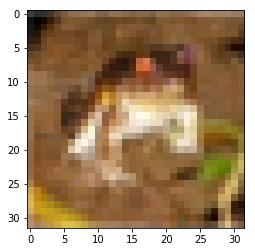

In [12]:
plt.imshow(train_loader.dataset.train_data[0])

In [28]:
train_loader.dataset.train_data[0].shape

(32, 32, 3)

In [33]:
class CIFARConvNet(nn.Module):
    def __init__(self):
        super(CIFARConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
#       self.layer2 = nn.Sequential(
#           nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2, stride=2)
#           )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16 * 16 * 32, 2000)
        self.fc2 = nn.Linear(2000, 10)
    
    def forward(self, x):
        out = self.layer1(x)
#        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

In [44]:
model = CIFARConvNet()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [45]:
# Training the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        # Run forward pass 
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        # Now backpropogate and apply Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted==labels).sum().item()
        acc_list.append(correct / total)
        
        if (i+1) % 100 == 0:
             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/500], Loss: 1.6822, Accuracy: 38.00%
Epoch [1/6], Step [200/500], Loss: 1.5131, Accuracy: 48.00%
Epoch [1/6], Step [300/500], Loss: 1.6586, Accuracy: 38.00%
Epoch [1/6], Step [400/500], Loss: 1.3480, Accuracy: 50.00%
Epoch [1/6], Step [500/500], Loss: 1.1068, Accuracy: 62.00%
Epoch [2/6], Step [100/500], Loss: 1.1499, Accuracy: 61.00%
Epoch [2/6], Step [200/500], Loss: 1.1338, Accuracy: 63.00%
Epoch [2/6], Step [300/500], Loss: 1.4204, Accuracy: 53.00%
Epoch [2/6], Step [400/500], Loss: 1.1640, Accuracy: 60.00%
Epoch [2/6], Step [500/500], Loss: 1.3914, Accuracy: 52.00%
Epoch [3/6], Step [100/500], Loss: 1.1372, Accuracy: 62.00%
Epoch [3/6], Step [200/500], Loss: 1.1338, Accuracy: 64.00%
Epoch [3/6], Step [300/500], Loss: 1.2651, Accuracy: 56.00%
Epoch [3/6], Step [400/500], Loss: 1.0678, Accuracy: 64.00%
Epoch [3/6], Step [500/500], Loss: 1.3918, Accuracy: 49.00%
Epoch [4/6], Step [100/500], Loss: 1.0103, Accuracy: 65.00%
Epoch [4/6], Step [200/500], Loss: 1.167

In [39]:
def evaluateAccuracy(model, test_loader): 
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted==labels).sum().item()
            total += labels.size(0)

        print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))
evaluateAccuracy(modelCIFAR, test_loader) 
# Save the model and plot
# torch.save(model.state_dict(), MODEL_PATH + 'cifar_conv_net_1(conv)_2_model.ckpt')

Test Accuracy of the model on the 10000 test images: 62.82 %


In [34]:
modelCIFAR = CIFARConvNet()
modelCIFAR.load_state_dict(torch.load(MODEL_PATH + 'cifar_conv_net_1(conv)_2_model.ckpt'))

In [42]:
varModel(modelCIFAR, test_loader)

0.09873133152723312

In [62]:
sigs = np.linspace(0, 60, 7) 
print(sigs)

[ 0. 10. 20. 30. 40. 50. 60.]


In [63]:
res, resSTD = varianceTest(modelCIFAR, sigs, dataset = 'cifar10', epochs = 6)

Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 0.0 is 0.09873133152723312. STD is 0.0
Computing variance of f(Y) where noise has sigma = 10.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 10.0 is 0.09569939474264781. STD is 0.00030008549997245743
Computing variance of f(Y) where noise has sigma = 20.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 20.0 is 0.0961563525100549. STD is 0.0002641318888111506
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise std 30.0 is 0.10990060120820999. STD is 0.0006765919734171862
Computing variance of f(Y) where noise has sigma = 40.0
Epoch 1 of 6
Epoch 2 of 6
Epoch 3 of 6
Epoch 4 of 6
Epoch 5 of 6
Epoch 6 of 6
Variance with noise st

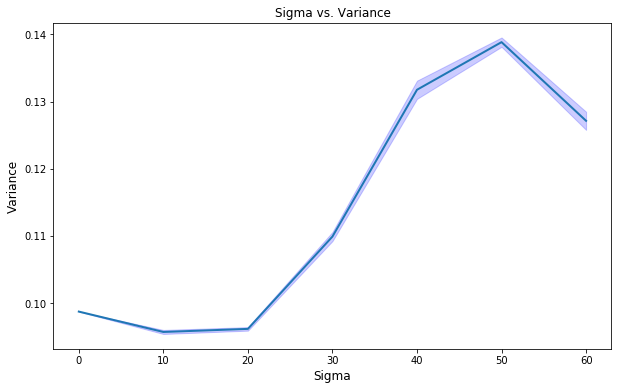

In [64]:
display(sigs, res, resSTD)

In [65]:
sigs2 = np.linspace(0, 120, 5)
print(sigs2)
res, resSTD = varianceTest(modelCIFAR, sigs2, dataset = 'cifar10', epochs = 3)

[  0.  30.  60.  90. 120.]
Computing variance of f(Y) where noise has sigma = 0.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 0.0 is 0.09873133152723312. STD is 0.0
Computing variance of f(Y) where noise has sigma = 30.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 30.0 is 0.11026227474212646. STD is 0.0002360646716600602
Computing variance of f(Y) where noise has sigma = 60.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 60.0 is 0.1259607175985972. STD is 0.001400404631134268
Computing variance of f(Y) where noise has sigma = 90.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 90.0 is 0.09092489878336589. STD is 0.009065838164751105
Computing variance of f(Y) where noise has sigma = 120.0
Epoch 1 of 3
Epoch 2 of 3
Epoch 3 of 3
Variance with noise std 120.0 is 0.06124102075894674. STD is 0.0016836775359124337


(5,) (5,) (5,)


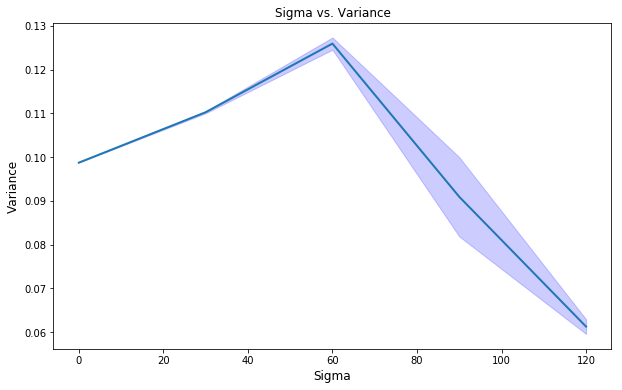

In [73]:
print(sigs2.shape, np.array(res).shape, np.array(resSTD).shape)
display(sigs2, res, resSTD)

In [25]:
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
noisy_test_dataset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, \
                                        transform=trans,download=False)
for i in range(len(noisy_test_dataset.test_data)):
    noisy_test_dataset.test_data[i] = addNoise(noisy_test_dataset.test_data[i], 30)

In [17]:
noisy_test_dataset.test_data

array([[[[158, 112,  49],
         [159, 111,  47],
         [165, 116,  51],
         ...,
         [137,  95,  36],
         [126,  91,  36],
         [116,  85,  33]],

        [[152, 112,  51],
         [151, 110,  40],
         [159, 114,  45],
         ...,
         [136,  95,  31],
         [125,  91,  32],
         [119,  88,  34]],

        [[151, 110,  47],
         [151, 109,  33],
         [158, 111,  36],
         ...,
         [139,  98,  34],
         [130,  95,  34],
         [120,  89,  33]],

        ...,

        [[ 68, 124, 177],
         [ 42, 100, 148],
         [ 31,  88, 137],
         ...,
         [ 38,  97, 146],
         [ 13,  64, 108],
         [ 40,  85, 127]],

        [[ 61, 116, 168],
         [ 49, 102, 148],
         [ 35,  85, 132],
         ...,
         [ 26,  82, 130],
         [ 29,  82, 126],
         [ 20,  64, 107]],

        [[ 54, 107, 160],
         [ 56, 105, 149],
         [ 45,  89, 132],
         ...,
         [ 24,  77, 124],
        

In [26]:
noisy_test_dataset.test_data[0]

array([[[128, 106,  37],
        [170, 137,   3],
        [176,  96,  47],
        ...,
        [104, 123,  33],
        [136, 135,   5],
        [133,  96,   0]],

       [[109, 124,  22],
        [109, 132,  89],
        [157,  97,   7],
        ...,
        [143, 102,  40],
        [123,  67,  49],
        [167,  32,  43]],

       [[109,  58,  77],
        [107,  96,  14],
        [105,  71,  48],
        ...,
        [173, 122,  22],
        [119,  62,  57],
        [109, 110,  93]],

       ...,

       [[ 77,  97, 156],
        [ 76, 101, 146],
        [ 53,  84, 168],
        ...,
        [ 45, 139, 128],
        [  0,  64,  99],
        [  8,  43, 124]],

       [[ 10, 140, 137],
        [ 61, 106, 161],
        [ 63,  96, 125],
        ...,
        [  0,  54,  82],
        [ 19,  62,  90],
        [ 13,  83, 132]],

       [[ 39,  93, 173],
        [132, 106, 127],
        [  0, 104, 131],
        ...,
        [ 37,  59,  99],
        [ 37, 184, 129],
        [ 72,  42, 102]]